In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
# some parameters
scale = True

### 1.Dataset loading

In [3]:
df = pd.read_csv('2016-09-19_79351_training.csv')

In [4]:
df

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training
...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,2016-07-31,DT,NaN,5,training,training
408542,0dfb685e3d705957ef9e0c472604b067,2016-07-31,DT,NaN,155,training,training
408543,918eb93c2d3b084614e3570886715f84,2016-07-31,DT,NaN,19,training,training
408544,918eb93c2d3b084614e3570886715f84,2016-07-31,DT,NaN,19,training,training


In [5]:
mcc = pd.read_csv('mcc_group_definition.csv')

In [6]:
mcc

,mcc_group,explanation
0,1,ATM
1,2,Groceries
2,3,Gastronomie
3,4,Shopping/(Fashion)
4,5,"Home and DIY, House Energy"
5,6,Travel/Hotel
6,7,Transport
7,8,Automotive/Gas
8,9,Family/Babies/Children
9,10,Entertainment/Leisure


In [7]:
types = pd.read_csv('transaction_types.csv')

In [8]:
types

,type,explanation,direction,agent
0,AR,Authorization reject,-,Card
1,AE,Authorization expired,In,Card
2,AV,Authorization Reversal,In,Card
3,BBU,Cash26 deposit,In,Partner
4,CT,Credit Transfer,In,Bank Account
5,DI,Dispute,In,Card
6,DR,Debit Reversal,In,Bank Account
7,PF,Credit Card refund by merchant,In,Card
8,PR,Presentment Reversal,In,Card
9,WU,Referral payment,In,Number26


#### merge three tables into one

In [9]:
df = df.merge(types, left_on='transaction_type',right_on='type', how='left').drop(columns=['type','transaction_type']).rename(columns={'explanation':'transaction_type'})

In [10]:
df

,user_id,transaction_date,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,transaction_type,direction,agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,NaN,350,training,training,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,NaN,202,training,training,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,NaN,291,training,training,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,NaN,214,training,training,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,NaN,272,training,training,Debit Transfer,Out,Bank Account
...,...,...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,2016-07-31,NaN,5,training,training,Debit Transfer,Out,Bank Account
408542,0dfb685e3d705957ef9e0c472604b067,2016-07-31,NaN,155,training,training,Debit Transfer,Out,Bank Account
408543,918eb93c2d3b084614e3570886715f84,2016-07-31,NaN,19,training,training,Debit Transfer,Out,Bank Account
408544,918eb93c2d3b084614e3570886715f84,2016-07-31,NaN,19,training,training,Debit Transfer,Out,Bank Account


In [11]:
df = df.merge(mcc, on='mcc_group', how='left')

In [12]:
df

,user_id,transaction_date,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,transaction_type,direction,agent,explanation
0,a78884f5e76951188c1e719d4956773a,2016-02-01,NaN,350,training,training,Debit Transfer,Out,Bank Account,NaN
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,NaN,202,training,training,Debit Transfer,Out,Bank Account,NaN
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,NaN,291,training,training,Debit Transfer,Out,Bank Account,NaN
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,NaN,214,training,training,Debit Transfer,Out,Bank Account,NaN
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,NaN,272,training,training,Debit Transfer,Out,Bank Account,NaN
...,...,...,...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,2016-07-31,NaN,5,training,training,Debit Transfer,Out,Bank Account,NaN
408542,0dfb685e3d705957ef9e0c472604b067,2016-07-31,NaN,155,training,training,Debit Transfer,Out,Bank Account,NaN
408543,918eb93c2d3b084614e3570886715f84,2016-07-31,NaN,19,training,training,Debit Transfer,Out,Bank Account,NaN
408544,918eb93c2d3b084614e3570886715f84,2016-07-31,NaN,19,training,training,Debit Transfer,Out,Bank Account,NaN


### 2. Exploratory Data Analysis

In [13]:
# check if the column mcc_group is empty
df.mcc_group.value_counts()

mcc_group
1.0     69807
2.0     50586
6.0     24672
3.0     20875
8.0     20610
4.0     20194
17.0    11466
16.0    11150
7.0     10888
10.0     7282
11.0     5803
5.0      3337
12.0      873
15.0      329
9.0       287
13.0      141
14.0       24
Name: count, dtype: int64

In [14]:
# fill empty cells with 0 - non-card-transaction
df['mcc_group'] = df['mcc_group'].fillna(0)
df['explanation'] = df['explanation'].fillna('non-card')

In [15]:
# check how many values in dataset_transaction, dataset_user columns
df.dataset_transaction.value_counts()

dataset_transaction
training    408546
Name: count, dtype: int64

In [16]:
df.dataset_user.value_counts()

dataset_user
training    408546
Name: count, dtype: int64

In [17]:
# remove them, columns with a single value are uninformative
df = df.drop(columns=['dataset_transaction','dataset_user'])

In [18]:
# check if there are any empty cells
df.isna().sum()

user_id                0
transaction_date       0
mcc_group              0
amount_n26_currency    0
transaction_type       0
direction              0
agent                  0
explanation            0
dtype: int64

In [19]:
#Since we need to predict data for an entire month, let's divide all the data by months
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['month'] = df['transaction_date'].dt.month
df = df.drop(columns=['transaction_date'])

In [20]:
df

,user_id,mcc_group,amount_n26_currency,transaction_type,direction,agent,explanation,month
0,a78884f5e76951188c1e719d4956773a,0.0,350,Debit Transfer,Out,Bank Account,non-card,2
1,b0333294fef6ff1299102a70ad46b126,0.0,202,Debit Transfer,Out,Bank Account,non-card,2
2,7b8d2a2780adae0cd0c248e92c1b28dc,0.0,291,Debit Transfer,Out,Bank Account,non-card,2
3,cc4abaa500f7db4390ae3f02bd36d805,0.0,214,Debit Transfer,Out,Bank Account,non-card,2
4,49b99d1d5ba028566639e8b3eb7c055b,0.0,272,Debit Transfer,Out,Bank Account,non-card,2
...,...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,0.0,5,Debit Transfer,Out,Bank Account,non-card,7
408542,0dfb685e3d705957ef9e0c472604b067,0.0,155,Debit Transfer,Out,Bank Account,non-card,7
408543,918eb93c2d3b084614e3570886715f84,0.0,19,Debit Transfer,Out,Bank Account,non-card,7
408544,918eb93c2d3b084614e3570886715f84,0.0,19,Debit Transfer,Out,Bank Account,non-card,7


In [21]:
# check how many unique users we have
unique_users = pd.DataFrame(df['user_id'].unique(),columns=['user_id'])
unique_users

,user_id
0,a78884f5e76951188c1e719d4956773a
1,b0333294fef6ff1299102a70ad46b126
2,7b8d2a2780adae0cd0c248e92c1b28dc
3,cc4abaa500f7db4390ae3f02bd36d805
4,49b99d1d5ba028566639e8b3eb7c055b
...,...
9995,b4b285b10f55b341e9778284b1fd00b6
9996,3b42490c90bc0df245e768a4376cbdc0
9997,4ec926714ae4507c1bef3e52967ac93b
9998,30dbfccded7367ba923bbe0309829717


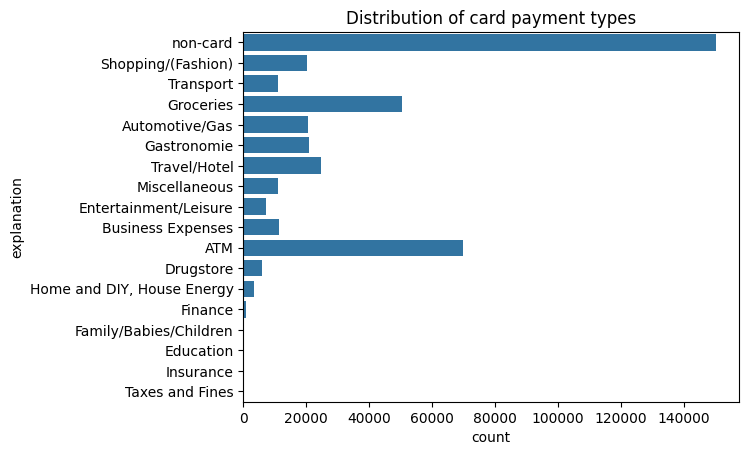

In [22]:
sns.countplot(data=df, y='explanation')
plt.title('Distribution of card payment types')
plt.show()

In [23]:
# since explanation and mcc_group mean the same, remove one of them 
df = df.drop(columns=['mcc_group'])
df = df.rename(columns={'explanation':'mcc_explanation'})

In [24]:
df

,user_id,amount_n26_currency,transaction_type,direction,agent,mcc_explanation,month
0,a78884f5e76951188c1e719d4956773a,350,Debit Transfer,Out,Bank Account,non-card,2
1,b0333294fef6ff1299102a70ad46b126,202,Debit Transfer,Out,Bank Account,non-card,2
2,7b8d2a2780adae0cd0c248e92c1b28dc,291,Debit Transfer,Out,Bank Account,non-card,2
3,cc4abaa500f7db4390ae3f02bd36d805,214,Debit Transfer,Out,Bank Account,non-card,2
4,49b99d1d5ba028566639e8b3eb7c055b,272,Debit Transfer,Out,Bank Account,non-card,2
...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,5,Debit Transfer,Out,Bank Account,non-card,7
408542,0dfb685e3d705957ef9e0c472604b067,155,Debit Transfer,Out,Bank Account,non-card,7
408543,918eb93c2d3b084614e3570886715f84,19,Debit Transfer,Out,Bank Account,non-card,7
408544,918eb93c2d3b084614e3570886715f84,19,Debit Transfer,Out,Bank Account,non-card,7


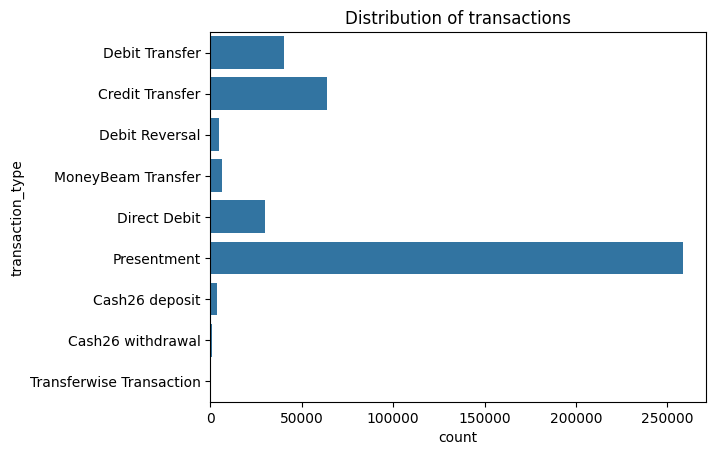

In [25]:
sns.countplot(data=df, y='transaction_type')
plt.title('Distribution of transactions')
plt.show()

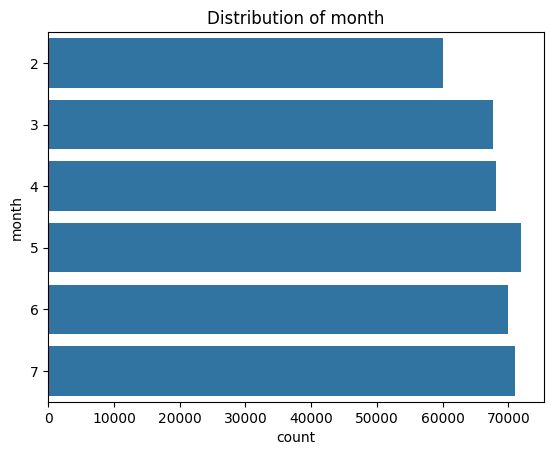

In [26]:
sns.countplot(data=df, y='month')
plt.title('Distribution of month')
plt.show()

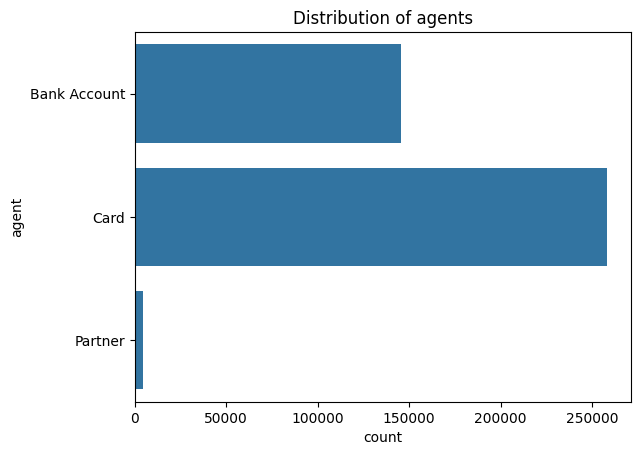

In [27]:
sns.countplot(data=df, y='agent')
plt.title('Distribution of agents')
plt.show()

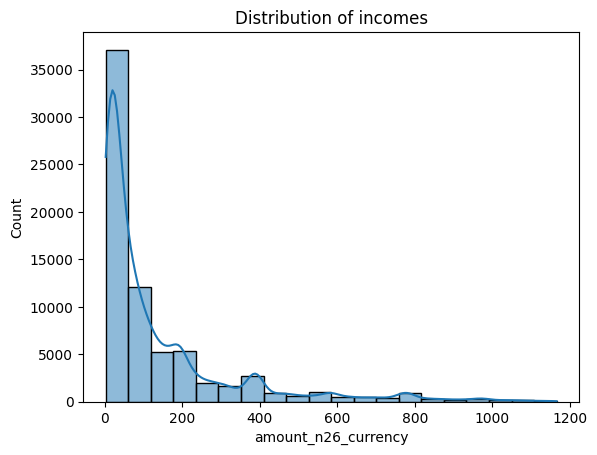

In [28]:
sns.histplot(df[df.direction == 'In']['amount_n26_currency'], bins=20, kde=True,)
plt.title('Distribution of incomes')
plt.show()

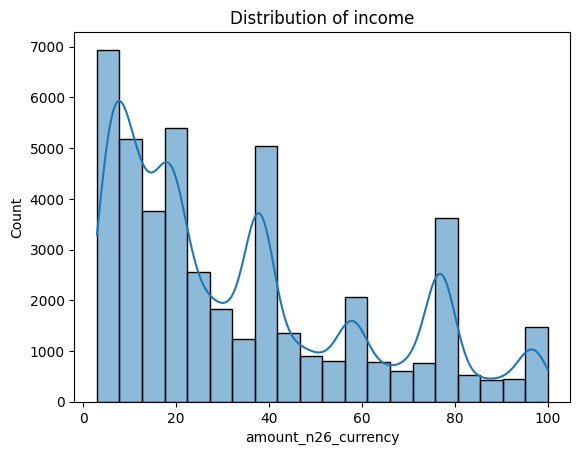

In [29]:
# let's take a closer look at the most popular income
sns.histplot(df[(df.direction == 'In')&(df.amount_n26_currency <= 100)]['amount_n26_currency'], bins=20, kde=True,)
plt.title('Distribution of income')
plt.show()

In [30]:
df[df.direction == 'In']['amount_n26_currency'].describe()

count    72125.000000
mean       138.968721
std        195.956845
min          3.000000
25%         19.000000
50%         58.000000
75%        175.000000
max       1166.000000
Name: amount_n26_currency, dtype: float64

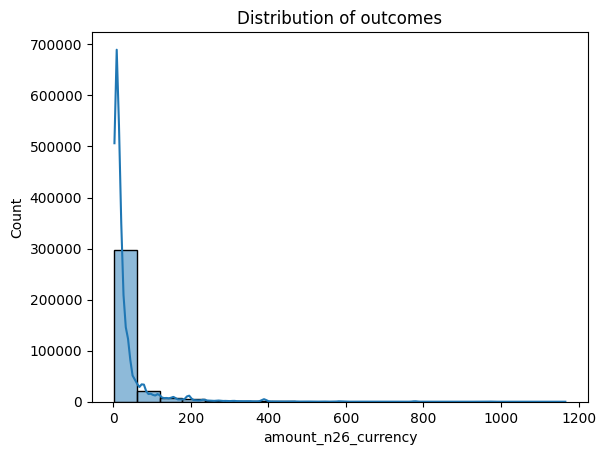

In [31]:
sns.histplot(df[df.direction == 'Out']['amount_n26_currency'], bins=20, kde=True,)
plt.title('Distribution of outcomes')
plt.show()

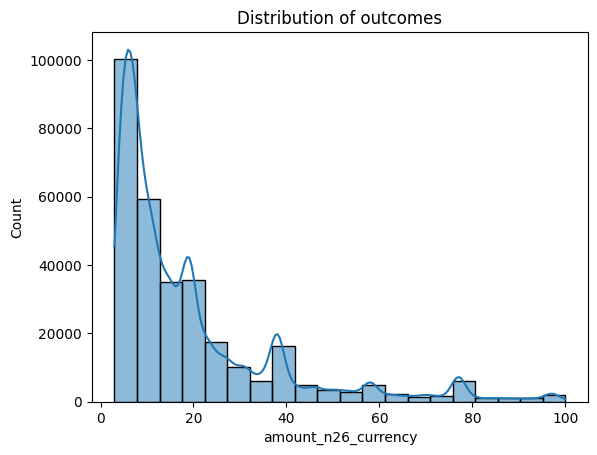

In [32]:
# let's take a closer look at the most popular outcome
sns.histplot(df[(df.direction == 'Out')&(df.amount_n26_currency <= 100)]['amount_n26_currency'], bins=20, kde=True,)
plt.title('Distribution of outcomes')
plt.show()

In [33]:
df[df.direction == 'Out']['amount_n26_currency'].describe()

count    336421.000000
mean         34.282845
std          70.930619
min           3.000000
25%           7.000000
50%          14.000000
75%          30.000000
max        1166.000000
Name: amount_n26_currency, dtype: float64

Conclusions:
* Income is generally higher than expenses, which is expected.
* Amount of almost 25% of outcomes operations is less then 10, however, income values are more spread out up to 200.
* Most of transactions are non-card or with ATM.
* A large share of agents is accounted for by Banc Account or Card, while the share of Partner is very low.
* The distribution of transactions across months shows almost no differences.
* The largest share of transactions is from Presentment, followed by Debit Transfer, Credit Transfer, and Direct Debit.

In [34]:
df

,user_id,amount_n26_currency,transaction_type,direction,agent,mcc_explanation,month
0,a78884f5e76951188c1e719d4956773a,350,Debit Transfer,Out,Bank Account,non-card,2
1,b0333294fef6ff1299102a70ad46b126,202,Debit Transfer,Out,Bank Account,non-card,2
2,7b8d2a2780adae0cd0c248e92c1b28dc,291,Debit Transfer,Out,Bank Account,non-card,2
3,cc4abaa500f7db4390ae3f02bd36d805,214,Debit Transfer,Out,Bank Account,non-card,2
4,49b99d1d5ba028566639e8b3eb7c055b,272,Debit Transfer,Out,Bank Account,non-card,2
...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,5,Debit Transfer,Out,Bank Account,non-card,7
408542,0dfb685e3d705957ef9e0c472604b067,155,Debit Transfer,Out,Bank Account,non-card,7
408543,918eb93c2d3b084614e3570886715f84,19,Debit Transfer,Out,Bank Account,non-card,7
408544,918eb93c2d3b084614e3570886715f84,19,Debit Transfer,Out,Bank Account,non-card,7


In [35]:
# transform the categorical data using one-hot encoding, as all categories are equally important
one_hot_features = ['transaction_type','agent','mcc_explanation']
df = pd.get_dummies(df, columns=one_hot_features, dtype=int)

In [36]:
df

,user_id,amount_n26_currency,direction,month,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,transaction_type_Debit Reversal,transaction_type_Debit Transfer,transaction_type_Direct Debit,...,mcc_explanation_Gastronomie,mcc_explanation_Groceries,"mcc_explanation_Home and DIY, House Energy",mcc_explanation_Insurance,mcc_explanation_Miscellaneous,mcc_explanation_Shopping/(Fashion),mcc_explanation_Taxes and Fines,mcc_explanation_Transport,mcc_explanation_Travel/Hotel,mcc_explanation_non-card
0,a78884f5e76951188c1e719d4956773a,350,Out,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,b0333294fef6ff1299102a70ad46b126,202,Out,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,7b8d2a2780adae0cd0c248e92c1b28dc,291,Out,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,cc4abaa500f7db4390ae3f02bd36d805,214,Out,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,49b99d1d5ba028566639e8b3eb7c055b,272,Out,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,5,Out,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
408542,0dfb685e3d705957ef9e0c472604b067,155,Out,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
408543,918eb93c2d3b084614e3570886715f84,19,Out,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
408544,918eb93c2d3b084614e3570886715f84,19,Out,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
if scale:
    scaler = StandardScaler()
    # scale only numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.drop('month')
    for col in numeric_columns:
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(-1,1))

In [38]:
df

,user_id,amount_n26_currency,direction,month,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,transaction_type_Debit Reversal,transaction_type_Debit Transfer,transaction_type_Direct Debit,...,mcc_explanation_Gastronomie,mcc_explanation_Groceries,"mcc_explanation_Home and DIY, House Energy",mcc_explanation_Insurance,mcc_explanation_Miscellaneous,mcc_explanation_Shopping/(Fashion),mcc_explanation_Taxes and Fines,mcc_explanation_Transport,mcc_explanation_Travel/Hotel,mcc_explanation_non-card
0,a78884f5e76951188c1e719d4956773a,2.656962,Out,2,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
1,b0333294fef6ff1299102a70ad46b126,1.334005,Out,2,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
2,7b8d2a2780adae0cd0c248e92c1b28dc,2.129567,Out,2,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
3,cc4abaa500f7db4390ae3f02bd36d805,1.441272,Out,2,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
4,49b99d1d5ba028566639e8b3eb7c055b,1.959728,Out,2,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408541,bc639c7495889105713fc6b1025264ac,-0.426959,Out,7,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
408542,0dfb685e3d705957ef9e0c472604b067,0.913876,Out,7,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
408543,918eb93c2d3b084614e3570886715f84,-0.301815,Out,7,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341
408544,918eb93c2d3b084614e3570886715f84,-0.301815,Out,7,-0.093771,-0.048074,-0.430338,-0.108193,3.013401,-0.280851,...,-0.23205,-0.375922,-0.090748,-0.018581,-0.167504,-0.228033,-0.007665,-0.16547,-0.253517,1.311341


In [39]:
in_df = df[df.direction == 'In'].drop(columns=['direction'])
out_df = df[df.direction == 'Out'].drop(columns=['direction'])

### 3. Dataset Creation

In [40]:
def create_dataset(df):
    # group the income (or expenses) by user_id, month and sum them
    grouped_by_month = df[['user_id','month','amount_n26_currency']].groupby(['user_id','month']).agg('sum')

    #convert them into rows
    res = grouped_by_month.pivot_table(index='user_id', columns='month', values='amount_n26_currency', aggfunc='sum', fill_value=0).reset_index()

    # other features will be called "types"
    # sum the frequency of each type occurrence over the entire period for each user
    types_df = df.groupby(['user_id']).agg('sum').drop(columns=['month'])

    # merge the table with grouped income (expenses) by month with the "types" table
    res = res.merge(types_df, on='user_id', how='outer').drop(columns='amount_n26_currency')

    # make sure that all users are present in our table, if not then fill cells with 0
    res = res.merge(unique_users, on='user_id', how='outer').fillna(0)
    return res

In [41]:
in_ = create_dataset(in_df)
out_ = create_dataset(out_df)

In [42]:
in_

,user_id,2,3,4,5,6,7,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,...,mcc_explanation_Gastronomie,mcc_explanation_Groceries,"mcc_explanation_Home and DIY, House Energy",mcc_explanation_Insurance,mcc_explanation_Miscellaneous,mcc_explanation_Shopping/(Fashion),mcc_explanation_Taxes and Fines,mcc_explanation_Transport,mcc_explanation_Travel/Hotel,mcc_explanation_non-card
0,000295594379774ab9ac2c78c946d615,2.129567,2.934068,0.000000,0.913876,0.556320,0.000000,10.383016,-0.192294,6.540923,...,-0.92820,-1.503689,-0.362993,-0.074323,-0.670017,-0.912133,-0.030659,-0.66188,-1.014070,5.245364
1,000aa792d73dd82b16a29692772d395a,0.000000,0.000000,0.000000,4.956369,0.000000,0.913876,-0.281312,-0.144221,6.971261,...,-0.69615,-1.127766,-0.272245,-0.055742,-0.502513,-0.684100,-0.022994,-0.49641,-0.760552,3.934023
2,0011103fe4ba1264342882b7ab98c641,3.005580,0.000000,0.565259,0.000000,4.739727,7.479248,-0.562623,-0.288441,13.942522,...,-1.39230,-2.255533,-0.544490,-0.111485,-1.005025,-1.368200,-0.045988,-0.99282,-1.521105,7.868045
3,001679c77c33d7efabf800596fb2a978,4.739727,4.846994,6.080562,9.792316,11.884019,7.081720,-0.750164,-0.384588,18.590029,...,-1.85640,-3.007377,-0.725987,-0.148646,-1.340034,-1.824267,-0.061318,-1.32376,-2.028139,10.490727
4,001e72a2f4c4376f10011735dde39cd5,1.827753,0.565259,0.000000,0.000000,0.000000,0.000000,-0.281312,-0.144221,6.971261,...,-0.69615,-1.127766,-0.272245,-0.055742,-0.502513,-0.684100,-0.022994,-0.49641,-0.760552,3.934023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,-0.301815,-0.301815,0.000000,-0.158792,-0.292876,42.657311,-0.192294,-1.721353,...,-0.92820,-1.503689,-0.362993,-0.074323,-0.670017,-0.912133,-0.030659,-0.66188,-1.014070,5.245364
9996,fff6ea4b3659a969c62c17c1d1655394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9997,fff9eec15875baad3df433c8780aa3bd,3.354197,-0.496362,2.478184,0.216642,-0.266059,0.000000,-0.562623,-0.288441,13.942522,...,-1.39230,-2.255533,-0.544490,-0.111485,-1.005025,-1.368200,-0.045988,-0.99282,-1.521105,7.868045
9998,fffd503ed2ecb63067b7369f4d668aed,0.647817,0.084666,1.262494,2.656962,1.611111,1.959728,-0.750164,-0.384588,18.590029,...,-1.85640,-3.007377,-0.725987,-0.148646,-1.340034,-1.824267,-0.061318,-1.32376,-2.028139,10.490727


In [43]:
def feature_engeneering(df):
    month=[2,3,4,5,6]

    # new feature - average value of income (expenses)
    df['avg'] = df[month].mean(axis=1)

    # a feature that indicates zero income (expenses) for the last month
    df['one_empty_month'] = np.where((df[6] == 0), 1, 0)
    # for the last 2 month
    df['two_empty_month'] = np.where((df[5] == 0) & (df[6] == 0), 1, 0)

    # a feature that indicates a decrease in income (expenses) for the last month compared to the previous one
    df['desc_1_month'] = np.where(df[6] < df[5], 1, 0)
    # for the last 2 month 
    df['desc_2_month'] = np.where((df[6] < df[5])&(df[5] < df[4]), 1, 0)

    # features that indicates the difference between the income (expenses) of the month and the average
    for el in month:
        df[f'diff_avg_{el}'] = df[el] - df['avg']

    return df

In [44]:
in_ = feature_engeneering(in_)
out_ = feature_engeneering(out_)

In [45]:
in_

,user_id,2,3,4,5,6,7,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,...,avg,one_empty_month,two_empty_month,desc_1_month,desc_2_month,diff_avg_2,diff_avg_3,diff_avg_4,diff_avg_5,diff_avg_6
0,000295594379774ab9ac2c78c946d615,2.129567,2.934068,0.000000,0.913876,0.556320,0.000000,10.383016,-0.192294,6.540923,...,1.306766,0,0,1,0,0.822801,1.627302,-1.306766,-0.392890,-0.750446
1,000aa792d73dd82b16a29692772d395a,0.000000,0.000000,0.000000,4.956369,0.000000,0.913876,-0.281312,-0.144221,6.971261,...,0.991274,1,0,1,0,-0.991274,-0.991274,-0.991274,3.965095,-0.991274
2,0011103fe4ba1264342882b7ab98c641,3.005580,0.000000,0.565259,0.000000,4.739727,7.479248,-0.562623,-0.288441,13.942522,...,1.662113,0,0,0,0,1.343467,-1.662113,-1.096854,-1.662113,3.077614
3,001679c77c33d7efabf800596fb2a978,4.739727,4.846994,6.080562,9.792316,11.884019,7.081720,-0.750164,-0.384588,18.590029,...,7.468724,0,0,0,0,-2.728997,-2.621730,-1.388161,2.323592,4.415295
4,001e72a2f4c4376f10011735dde39cd5,1.827753,0.565259,0.000000,0.000000,0.000000,0.000000,-0.281312,-0.144221,6.971261,...,0.478602,1,1,0,0,1.349150,0.086657,-0.478602,-0.478602,-0.478602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,-0.301815,-0.301815,0.000000,-0.158792,-0.292876,42.657311,-0.192294,-1.721353,...,-0.152484,0,0,1,0,0.152484,-0.149330,-0.149330,0.152484,-0.006308
9996,fff6ea4b3659a969c62c17c1d1655394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
9997,fff9eec15875baad3df433c8780aa3bd,3.354197,-0.496362,2.478184,0.216642,-0.266059,0.000000,-0.562623,-0.288441,13.942522,...,1.057320,0,0,1,1,2.296877,-1.553683,1.420864,-0.840679,-1.323379
9998,fffd503ed2ecb63067b7369f4d668aed,0.647817,0.084666,1.262494,2.656962,1.611111,1.959728,-0.750164,-0.384588,18.590029,...,1.252610,0,0,1,0,-0.604793,-1.167944,0.009883,1.404352,0.358501


In [46]:
# also add to the features the difference between income and expenses for each month
# for this aim create combined dataset
combined = in_.merge(out_, on='user_id', how='outer')
combined.columns = combined.columns.str.replace('_x', '_out', regex=True)
combined.columns = combined.columns.str.replace('_y', '_in', regex=True)
for month in [2,3,4,5,6]:
    combined[f'in_out_{month}'] = combined[f'{month}_in'] - combined[f'{month}_out']

combined=combined[['user_id', 'in_out_2', 'in_out_3', 'in_out_4', 'in_out_5', 'in_out_6']]

In [47]:
combined

,user_id,in_out_2,in_out_3,in_out_4,in_out_5,in_out_6
0,000295594379774ab9ac2c78c946d615,-0.098328,-1.325572,0.000000,-0.480593,-2.778397
1,000aa792d73dd82b16a29692772d395a,-0.539455,-0.230303,-1.687851,-5.772424,-0.324415
2,0011103fe4ba1264342882b7ab98c641,-3.005580,-0.230303,-0.378048,-0.675140,-4.833839
3,001679c77c33d7efabf800596fb2a978,2.352533,-3.235883,-9.327410,-9.875298,-5.326998
4,001e72a2f4c4376f10011735dde39cd5,-2.905650,-1.801949,-1.251953,-0.031539,0.000000
...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,-0.071511,-0.071511,0.000000,-0.080450
9996,fff6ea4b3659a969c62c17c1d1655394,1.262494,-0.085173,-0.400143,-0.800285,0.000000
9997,fff9eec15875baad3df433c8780aa3bd,-3.582392,0.042080,-2.625930,-0.166129,-2.076947
9998,fffd503ed2ecb63067b7369f4d668aed,-0.732990,-2.854631,-2.818369,-3.830573,-6.214057


In [48]:
in_ = in_.merge(combined, on='user_id', how='outer')
out_ = out_.merge(combined, on='user_id',how='outer')

In [49]:
in_

,user_id,2,3,4,5,6,7,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,...,diff_avg_2,diff_avg_3,diff_avg_4,diff_avg_5,diff_avg_6,in_out_2,in_out_3,in_out_4,in_out_5,in_out_6
0,000295594379774ab9ac2c78c946d615,2.129567,2.934068,0.000000,0.913876,0.556320,0.000000,10.383016,-0.192294,6.540923,...,0.822801,1.627302,-1.306766,-0.392890,-0.750446,-0.098328,-1.325572,0.000000,-0.480593,-2.778397
1,000aa792d73dd82b16a29692772d395a,0.000000,0.000000,0.000000,4.956369,0.000000,0.913876,-0.281312,-0.144221,6.971261,...,-0.991274,-0.991274,-0.991274,3.965095,-0.991274,-0.539455,-0.230303,-1.687851,-5.772424,-0.324415
2,0011103fe4ba1264342882b7ab98c641,3.005580,0.000000,0.565259,0.000000,4.739727,7.479248,-0.562623,-0.288441,13.942522,...,1.343467,-1.662113,-1.096854,-1.662113,3.077614,-3.005580,-0.230303,-0.378048,-0.675140,-4.833839
3,001679c77c33d7efabf800596fb2a978,4.739727,4.846994,6.080562,9.792316,11.884019,7.081720,-0.750164,-0.384588,18.590029,...,-2.728997,-2.621730,-1.388161,2.323592,4.415295,2.352533,-3.235883,-9.327410,-9.875298,-5.326998
4,001e72a2f4c4376f10011735dde39cd5,1.827753,0.565259,0.000000,0.000000,0.000000,0.000000,-0.281312,-0.144221,6.971261,...,1.349150,0.086657,-0.478602,-0.478602,-0.478602,-2.905650,-1.801949,-1.251953,-0.031539,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,-0.301815,-0.301815,0.000000,-0.158792,-0.292876,42.657311,-0.192294,-1.721353,...,0.152484,-0.149330,-0.149330,0.152484,-0.006308,0.000000,-0.071511,-0.071511,0.000000,-0.080450
9996,fff6ea4b3659a969c62c17c1d1655394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.262494,-0.085173,-0.400143,-0.800285,0.000000
9997,fff9eec15875baad3df433c8780aa3bd,3.354197,-0.496362,2.478184,0.216642,-0.266059,0.000000,-0.562623,-0.288441,13.942522,...,2.296877,-1.553683,1.420864,-0.840679,-1.323379,-3.582392,0.042080,-2.625930,-0.166129,-2.076947
9998,fffd503ed2ecb63067b7369f4d668aed,0.647817,0.084666,1.262494,2.656962,1.611111,1.959728,-0.750164,-0.384588,18.590029,...,-0.604793,-1.167944,0.009883,1.404352,0.358501,-0.732990,-2.854631,-2.818369,-3.830573,-6.214057


In [50]:
# create two more features
def feature_engeneering2(df):
    # a feature that indicates unprofitable last month
    df['one_unprofit_month'] = np.where((df['in_out_6'] < 0), 1, 0)
    # last 2 month
    df['two_unprofit_month'] = np.where((df['in_out_6'] < 0)&(df['in_out_5'] < 0), 1, 0)    
    return df

In [51]:
in_ = feature_engeneering2(in_)
out_ = feature_engeneering2(out_)

In [1]:
in_

NameError: name 'in_' is not defined

### 3. Create Train and Test Samples

In [52]:
unique_users = [user[0] for user in unique_users.values.tolist()]

In [53]:
target = '7'

In [54]:
def train_test_split(df):
    # assign string names to all columns
    df.columns = df.columns.astype(str)
    
    # split users into train and test randomly
    split_size = int(len(unique_users)*0.2)
    test_users = random.sample(unique_users, split_size)
    print("len test_users:", len(test_users))
    train_users = [item for item in unique_users if item not in test_users]
    print("len train_users:", len(train_users))
    
    # split dataset into train and test
    df_train = df[df['user_id'].isin(train_users)]
    df_test = df[df['user_id'].isin(test_users)]

    # split data into target and features
    X_train, X_test = df_train.drop(columns=[target,'user_id']), df_test.drop(columns=[target,'user_id'])
    y_train, y_test = df_train[target], df_test[target]
    
    return X_train, X_test, y_train, y_test

In [55]:
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(in_)

len test_users: 2000
len train_users: 8000


In [56]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(out_)

len test_users: 2000
len train_users: 8000


In [57]:
X_train_in

,2,3,4,5,6,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,transaction_type_Debit Reversal,transaction_type_Debit Transfer,...,diff_avg_4,diff_avg_5,diff_avg_6,in_out_2,in_out_3,in_out_4,in_out_5,in_out_6,one_unprofit_month,two_unprofit_month
0,2.129567,2.934068,0.000000,0.913876,0.556320,10.383016,-0.192294,6.540923,-0.432772,-1.327404,...,-1.306766,-0.392890,-0.750446,-0.098328,-1.325572,0.000000,-0.480593,-2.778397,1,1
1,0.000000,0.000000,0.000000,4.956369,0.000000,-0.281312,-0.144221,6.971261,-0.324579,-0.995553,...,-0.991274,3.965095,-0.991274,-0.539455,-0.230303,-1.687851,-5.772424,-0.324415,1,1
2,3.005580,0.000000,0.565259,0.000000,4.739727,-0.562623,-0.288441,13.942522,-0.649158,-1.991106,...,-1.096854,-1.662113,3.077614,-3.005580,-0.230303,-0.378048,-0.675140,-4.833839,1,1
3,4.739727,4.846994,6.080562,9.792316,11.884019,-0.750164,-0.384588,18.590029,-0.865545,-2.654808,...,-1.388161,2.323592,4.415295,2.352533,-3.235883,-9.327410,-9.875298,-5.326998,1,1
4,1.827753,0.565259,0.000000,0.000000,0.000000,-0.281312,-0.144221,6.971261,-0.324579,-0.995553,...,-0.478602,-0.478602,-0.478602,-2.905650,-1.801949,-1.251953,-0.031539,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,-0.301815,-0.301815,0.000000,-0.158792,42.657311,-0.192294,-1.721353,-0.432772,-1.327404,...,-0.149330,0.152484,-0.006308,0.000000,-0.071511,-0.071511,0.000000,-0.080450,1,0
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.262494,-0.085173,-0.400143,-0.800285,0.000000,0,0
9997,3.354197,-0.496362,2.478184,0.216642,-0.266059,-0.562623,-0.288441,13.942522,-0.649158,-1.991106,...,1.420864,-0.840679,-1.323379,-3.582392,0.042080,-2.625930,-0.166129,-2.076947,1,1
9998,0.647817,0.084666,1.262494,2.656962,1.611111,-0.750164,-0.384588,18.590029,-0.865545,-2.654808,...,0.009883,1.404352,0.358501,-0.732990,-2.854631,-2.818369,-3.830573,-6.214057,1,1


### 4. Income Model Building

#### 4.1 Logistic Regression

In [58]:
model_lr = LinearRegression()
model_lr.fit(X_train_in, y_train_in)

LinearRegression()

In [59]:
y_pred_in = model_lr.predict(X_test_in)

In [60]:
def regression_plot1(y_test,y_pred):    
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Real values')
    plt.ylabel('Presicted values')
    plt.title('Real vs Pred')
    plt.legend()
    plt.grid(True)
    plt.show()

In [61]:
def regression_plot2(y_test,y_pred):    
    plt.figure(figsize=(10,6))
    
    # 100 points of real test data
    plt.plot([i for i in range(100)],y_test[:100])    
    # 100 points of predicted data
    plt.plot([i for i in range(100)],y_pred[:100])
    
    plt.xlabel('Index of point')
    plt.ylabel('Pred/real values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [62]:
results = []
mse_lr = mean_squared_error(y_test_in, y_pred_in)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_in, y_pred_in)
r2_lr = r2_score(y_test_in, y_pred_in)

print(f"Mean Squared Error: {mse_lr}")
print(f"Root Mean Squared Error: {rmse_lr}")
print(f"Mean Absolute Error: {mae_lr}")
print(f"R-squared: {r2_lr}")

results.append([mse_lr, rmse_lr, mae_lr, r2_lr])

Mean Squared Error: 4.003304141462609
Root Mean Squared Error: 2.0008258648524637
Mean Absolute Error: 1.1527378113553357
R-squared: 0.3336810152141628


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


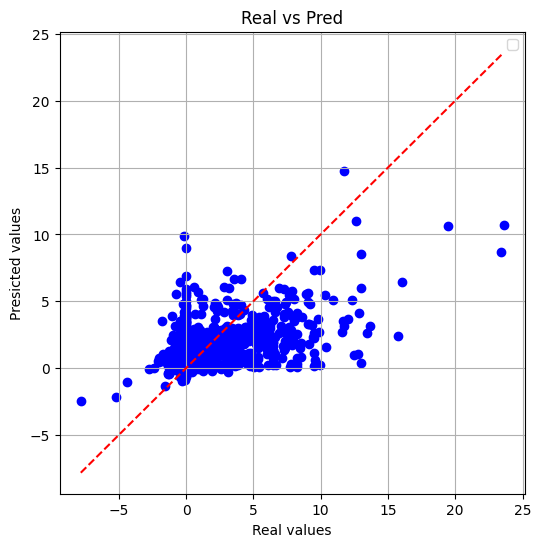

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


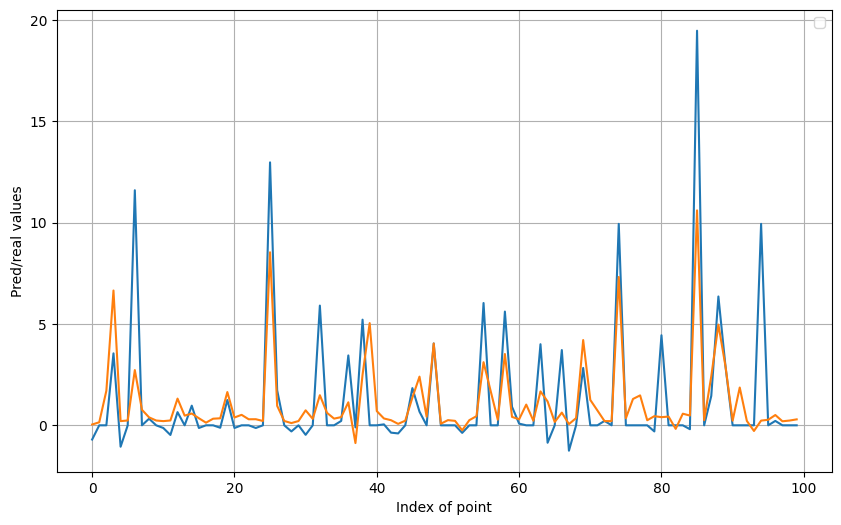

In [63]:
regression_plot1(y_test_in,y_pred_in)
regression_plot2(y_test_in,y_pred_in)

#### 4.2 Lasso regression

In [64]:
ridge_model = Lasso(alpha=1.0)
ridge_model.fit(X_train_in, y_train_in)

Lasso()

In [65]:
y_pred_in = ridge_model.predict(X_test_in)

In [66]:
mse_lasso = mean_squared_error(y_test_in, y_pred_in)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test_in, y_pred_in)
r2_lasso = r2_score(y_test_in, y_pred_in)

print(f"Mean Squared Error: {mse_lasso}")
print(f"Root Mean Squared Error: {rmse_lasso}")
print(f"Mean Absolute Error: {mae_lasso}")
print(f"R-squared: {r2_lasso}")

results.append([mse_lasso, rmse_lasso, mae_lasso, r2_lasso])

Mean Squared Error: 4.272266076853572
Root Mean Squared Error: 2.0669460749747612
Mean Absolute Error: 1.2503914144622477
R-squared: 0.28891438310155393


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


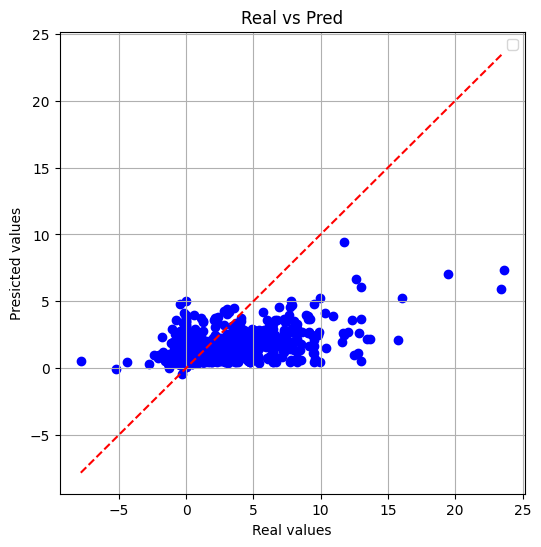

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


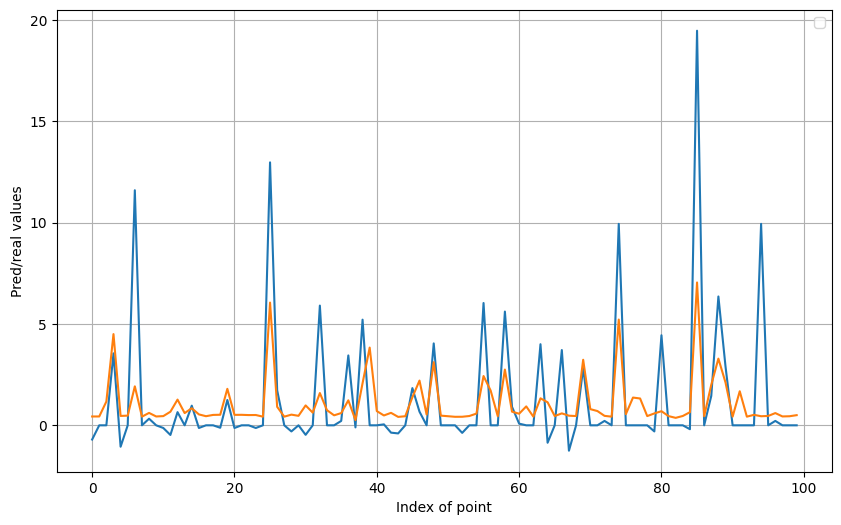

In [67]:
regression_plot1(y_test_in,y_pred_in)
regression_plot2(y_test_in,y_pred_in)

#### 4.3 Random forest

In [68]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_in, y_train_in)

RandomForestRegressor(random_state=42)

In [69]:
y_pred_in = rf_model.predict(X_test_in)

In [70]:
mse_rf = mean_squared_error(y_test_in, y_pred_in)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_in, y_pred_in)
r2_rf = r2_score(y_test_in, y_pred_in)

print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-squared: {r2_rf}")

results.append([mse_rf, rmse_rf, mae_rf, r2_rf])

Mean Squared Error: 4.143120578935917
Root Mean Squared Error: 2.0354656909257685
Mean Absolute Error: 1.1439338858257748
R-squared: 0.3104096515151884


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


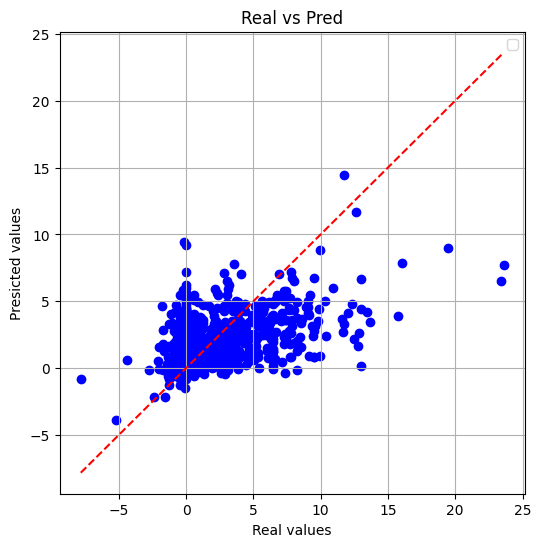

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


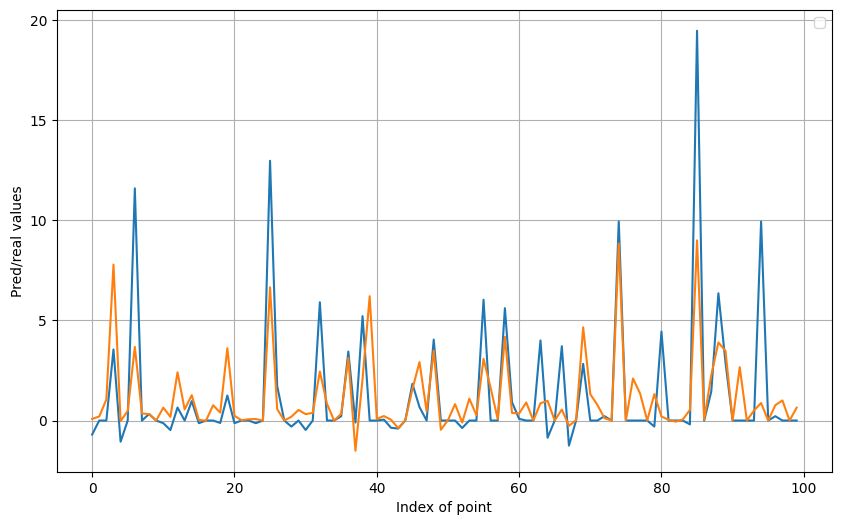

In [71]:
regression_plot1(y_test_in,y_pred_in)
regression_plot2(y_test_in,y_pred_in)

#### 4.4 Catboost

In [72]:
model_ctb = CatBoostRegressor(iterations=500, 
                           learning_rate=0.01, 
                           depth=6, 
                           loss_function='RMSE', 
                           verbose=50)
model_ctb.fit(X_train_in, y_train_in, eval_set=(X_test_in, y_test_in))

0:	learn: 2.3941338	test: 2.4452223	best: 2.4452223 (0)	total: 263ms	remaining: 2m 11s
50:	learn: 2.1575205	test: 2.2245801	best: 2.2245801 (50)	total: 715ms	remaining: 6.3s
100:	learn: 2.0350410	test: 2.1147908	best: 2.1147908 (100)	total: 1.19s	remaining: 4.68s
150:	learn: 1.9667374	test: 2.0618138	best: 2.0618138 (150)	total: 1.67s	remaining: 3.87s
200:	learn: 1.9238946	test: 2.0342116	best: 2.0342116 (200)	total: 2.35s	remaining: 3.5s
250:	learn: 1.8975445	test: 2.0205114	best: 2.0205114 (250)	total: 3.17s	remaining: 3.15s
300:	learn: 1.8789171	test: 2.0130758	best: 2.0130353 (299)	total: 4.36s	remaining: 2.88s
350:	learn: 1.8646682	test: 2.0087115	best: 2.0087115 (350)	total: 5.2s	remaining: 2.21s
400:	learn: 1.8508815	test: 2.0046810	best: 2.0046596 (399)	total: 6.15s	remaining: 1.52s
450:	learn: 1.8396021	test: 2.0033316	best: 2.0033316 (450)	total: 6.83s	remaining: 743ms
499:	learn: 1.8279473	test: 2.0020687	best: 2.0020687 (499)	total: 7.45s	remaining: 0us

bestTest = 2.002068

In [73]:
y_pred_in = model_ctb.predict(X_test_in)

In [74]:
mse_ctb = mean_squared_error(y_test_in, y_pred_in)
rmse_ctb = np.sqrt(mse_ctb)
mae_ctb = mean_absolute_error(y_test_in, y_pred_in)
r2_ctb = r2_score(y_test_in, y_pred_in)

print(f"Mean Squared Error: {mse_ctb}")
print(f"Root Mean Squared Error: {rmse_ctb}")
print(f"Mean Absolute Error: {mae_ctb}")
print(f"R-squared: {r2_ctb}")

results.append([mse_ctb, rmse_ctb, mae_ctb, r2_ctb])

Mean Squared Error: 4.008279070739887
Root Mean Squared Error: 2.002068697807317
Mean Absolute Error: 1.1342151907572091
R-squared: 0.33285297674686654


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


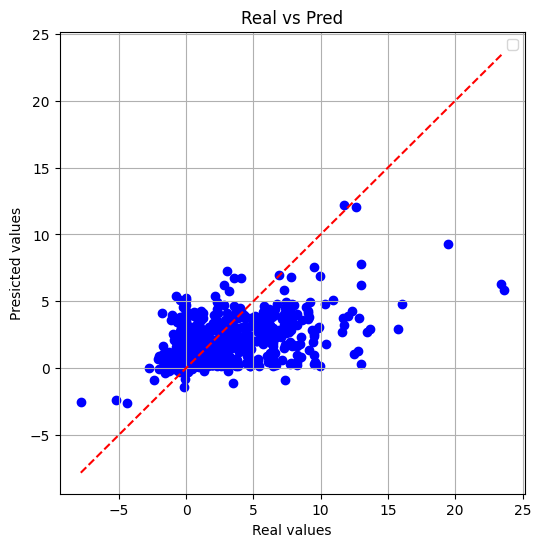

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


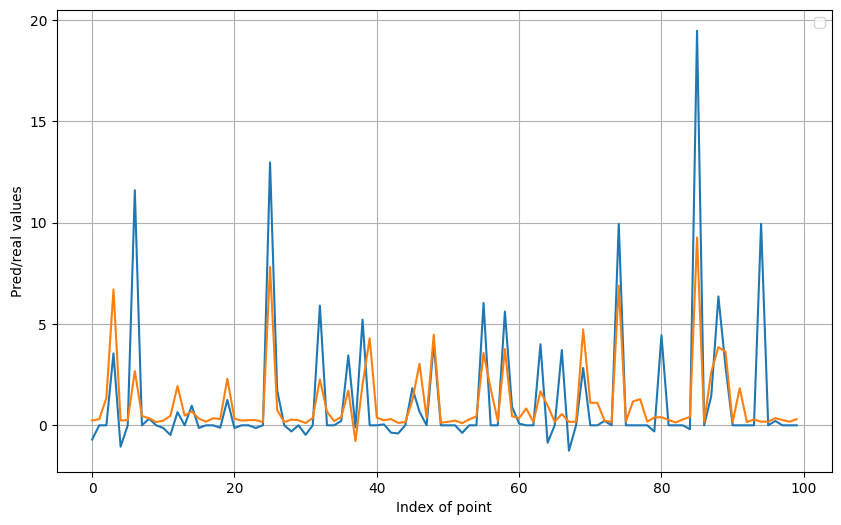

In [75]:
regression_plot1(y_test_in,y_pred_in)
regression_plot2(y_test_in,y_pred_in)

#### 4.5 Neural net

In [76]:
model_nn = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train_in.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        
        layers.Dense(1)
    ])

model_nn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mae',  # Переключаемся на среднюю абсолютную ошибку (MAE)
        metrics=['mse']
    )

history = model_nn.fit(X_train_in, y_train_in, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
200/200 [==============================] - 13s 4ms/step - loss: 2.2864 - mse: 5.2216 - val_loss: 1.8754 - val_mse: 4.5661
Epoch 2/100
200/200 [==============================] - 1s 4ms/step - loss: 1.8185 - mse: 4.7714 - val_loss: 1.5781 - val_mse: 4.6768
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 1.5402 - mse: 4.4858 - val_loss: 1.4087 - val_mse: 4.7918
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 1.3739 - mse: 4.6994 - val_loss: 1.2580 - val_mse: 4.6962
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 1.2589 - mse: 4.5221 - val_loss: 1.1493 - val_mse: 4.4592
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 1.1828 - mse: 4.4904 - val_loss: 1.0866 - val_mse: 4.2962
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 1.1441 - mse: 4.5193 - val_loss: 1.0677 - val_mse: 4.4431
Epoch 8/100
200/200 [==============================] - 1s 3ms/step -

In [77]:
y_pred_in = model_nn.predict(X_test_in)

63/63 [==============================] - 0s 1ms/step


In [78]:
mse_nn = mean_squared_error(y_test_in, y_pred_in)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test_in, y_pred_in)
r2_nn = r2_score(y_test_in, y_pred_in)

print(f"Mean Squared Error: {mse_nn}")
print(f"Root Mean Squared Error: {rmse_nn}")
print(f"Mean Absolute Error: {mae_nn}")
print(f"R-squared: {r2_nn}")

results.append([mse_nn, rmse_nn, mae_nn, r2_nn])

Mean Squared Error: 4.212724435542806
Root Mean Squared Error: 2.0524922498130915
Mean Absolute Error: 0.9695666294846806
R-squared: 0.29882462838613455


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


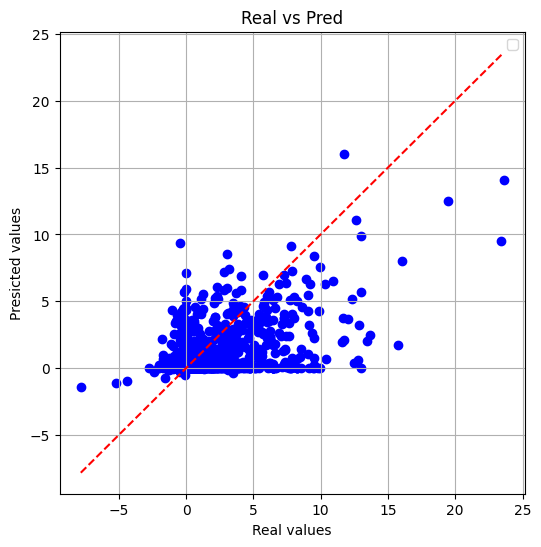

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


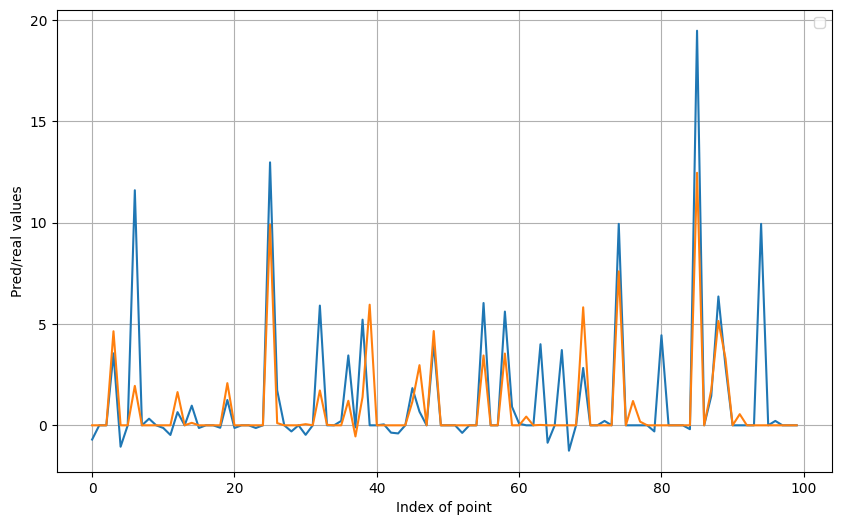

In [79]:
regression_plot1(y_test_in,y_pred_in)
regression_plot2(y_test_in,y_pred_in)

In [80]:
columns = ['MSE', 'RMSE', 'MAE', 'R2']
index = ['Logistic Regression', 'Lasso', 'Random Forest','CatBoost','Neural Network']
results_df = pd.DataFrame(results, columns=columns, index=index)

In [81]:
len(results)

5

In [82]:
results_df

,MSE,RMSE,MAE,R2
Logistic Regression,4.003304,2.000826,1.152738,0.333681
Lasso,4.272266,2.066946,1.250391,0.288914
Random Forest,4.143121,2.035466,1.143934,0.310410
CatBoost,4.008279,2.002069,1.134215,0.332853
Neural Network,4.212724,2.052492,0.969567,0.298825


### 5. Outcome Model Building

In [83]:
out_

,user_id,2,3,4,5,6,7,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,...,diff_avg_4,diff_avg_5,diff_avg_6,in_out_2,in_out_3,in_out_4,in_out_5,in_out_6,one_unprofit_month,two_unprofit_month
0,000295594379774ab9ac2c78c946d615,2.031239,1.608496,0.000000,0.433284,-2.222077,-0.391204,-1.312788,-0.673030,-6.024735,...,-0.370188,0.063095,-2.592266,-0.098328,-1.325572,0.000000,-0.480593,-2.778397,1,1
1,000aa792d73dd82b16a29692772d395a,-0.539455,-0.230303,-1.687851,-0.816055,-0.324415,-0.467438,-2.062952,-1.057618,-9.467441,...,-0.968235,-0.096439,0.395201,-0.539455,-0.230303,-1.687851,-5.772424,-0.324415,1,1
2,0011103fe4ba1264342882b7ab98c641,0.000000,-0.230303,0.187211,-0.675140,-0.094112,0.992301,-2.438035,-1.249912,-11.188794,...,0.349680,-0.512671,0.068357,-3.005580,-0.230303,-0.378048,-0.675140,-4.833839,1,1
3,001679c77c33d7efabf800596fb2a978,7.092260,1.611111,-3.246848,-0.082982,6.557021,4.945911,-6.751480,-3.461296,-30.984352,...,-5.632960,-2.469095,4.170909,2.352533,-3.235883,-9.327410,-9.875298,-5.326998,1,1
4,001e72a2f4c4376f10011735dde39cd5,-1.077898,-1.236690,-1.251953,-0.031539,0.000000,0.000000,-1.781641,-0.913398,-8.176426,...,-0.532337,0.688077,0.719616,-2.905650,-1.801949,-1.251953,-0.031539,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,-0.373326,-0.373326,0.000000,-0.239242,-0.418020,-0.375082,-0.192294,-1.721353,...,-0.176147,0.197179,-0.042063,0.000000,-0.071511,-0.071511,0.000000,-0.080450,1,0
9996,fff6ea4b3659a969c62c17c1d1655394,1.262494,-0.085173,-0.400143,-0.800285,0.000000,-0.274998,-0.656394,-0.336515,-3.012368,...,-0.395521,-0.795664,0.004621,1.262494,-0.085173,-0.400143,-0.800285,0.000000,0,0
9997,fff9eec15875baad3df433c8780aa3bd,-0.228195,-0.454282,-0.147745,0.050512,-2.343006,-0.409081,-2.344264,-1.201839,-10.758456,...,0.476798,0.675056,-1.718462,-3.582392,0.042080,-2.625930,-0.166129,-2.076947,1,1
9998,fffd503ed2ecb63067b7369f4d668aed,-0.085173,-2.769965,-1.555876,-1.173611,-4.602946,-1.384435,-3.750822,-1.922942,-17.213529,...,0.481638,0.863903,-2.565432,-0.732990,-2.854631,-2.818369,-3.830573,-6.214057,1,1


#### 5.1 Logistic Regression

In [84]:
model_lr = LinearRegression()
model_lr.fit(X_train_out, y_train_out)
y_pred_out = model_lr.predict(X_test_out)

In [85]:
mse_lr = mean_squared_error(y_test_out, y_pred_out)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_out, y_pred_out)
r2_lr = r2_score(y_test_out, y_pred_out)

print(f"Mean Squared Error: {mse_lr}")
print(f"Root Mean Squared Error: {rmse_lr}")
print(f"Mean Absolute Error: {mae_lr}")
print(f"R-squared: {r2_lr}")

Mean Squared Error: 6.588856546156736
Root Mean Squared Error: 2.5668768077484234
Mean Absolute Error: 1.2597953696079458
R-squared: 0.40813515301133607


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


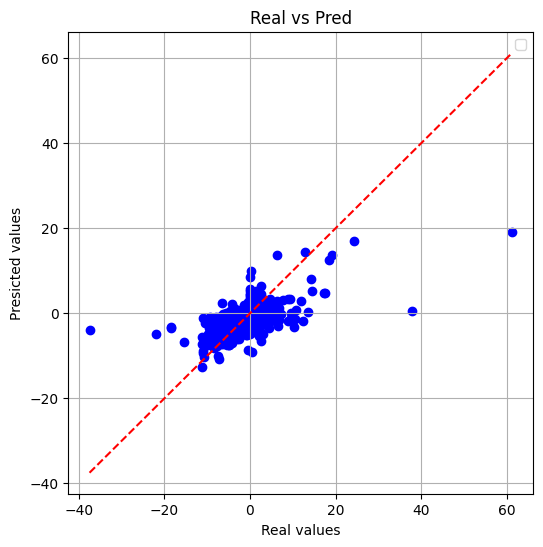

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


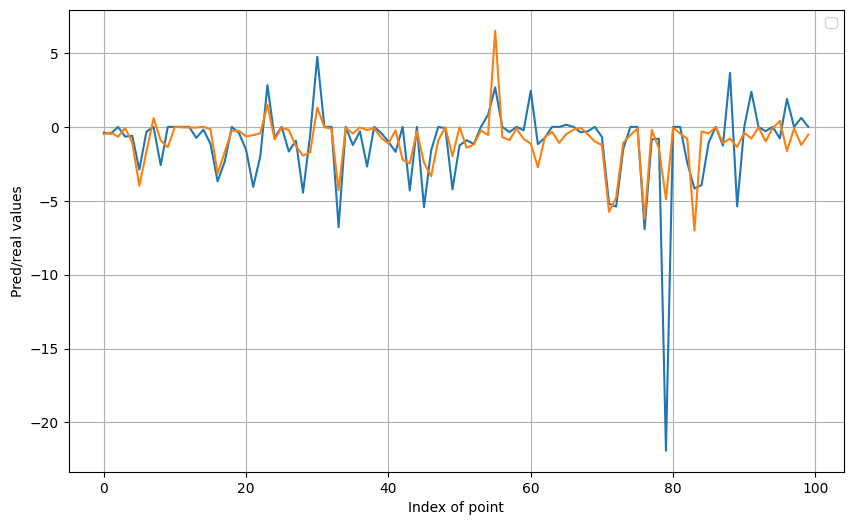

In [86]:
regression_plot1(y_test_out, y_pred_out)
regression_plot2(y_test_out, y_pred_out)

#### 5.2 Catboost

In [87]:
model_ctb_out = CatBoostRegressor(iterations=500, 
                                  learning_rate=0.01,                                  
                                  depth=6, 
                                  loss_function='RMSE', 
                                  verbose=50)
model_ctb_out.fit(X_train_out, y_train_out, eval_set=(X_test_out, y_test_out))

0:	learn: 2.6998122	test: 3.3279203	best: 3.3279203 (0)	total: 16.7ms	remaining: 8.32s
50:	learn: 2.3521070	test: 3.0248790	best: 3.0248790 (50)	total: 568ms	remaining: 5s
100:	learn: 2.1696004	test: 2.8720358	best: 2.8720358 (100)	total: 1.1s	remaining: 4.33s
150:	learn: 2.0657331	test: 2.7918908	best: 2.7918908 (150)	total: 1.61s	remaining: 3.73s
200:	learn: 1.9998754	test: 2.7422001	best: 2.7422001 (200)	total: 2.12s	remaining: 3.15s
250:	learn: 1.9531896	test: 2.7136706	best: 2.7136706 (250)	total: 2.65s	remaining: 2.63s
300:	learn: 1.9178171	test: 2.6940780	best: 2.6940780 (300)	total: 3.19s	remaining: 2.11s
350:	learn: 1.8887971	test: 2.6822749	best: 2.6822749 (350)	total: 3.78s	remaining: 1.6s
400:	learn: 1.8639644	test: 2.6738219	best: 2.6738219 (400)	total: 4.27s	remaining: 1.05s
450:	learn: 1.8427431	test: 2.6662857	best: 2.6662857 (450)	total: 4.77s	remaining: 519ms
499:	learn: 1.8237002	test: 2.6609036	best: 2.6609036 (499)	total: 5.24s	remaining: 0us

bestTest = 2.66090357

In [88]:
y_pred_out = model_ctb_out.predict(X_test_out)

In [89]:
mse_ctb = mean_squared_error(y_test_out, y_pred_out)
rmse_ctb = np.sqrt(mse_ctb)
mae_ctb = mean_absolute_error(y_test_out, y_pred_out)
r2_ctb = r2_score(y_test_out, y_pred_out)

print(f"Mean Squared Error: {mse_ctb}")
print(f"Root Mean Squared Error: {rmse_ctb}")
print(f"Mean Absolute Error: {mae_ctb}")
print(f"R-squared: {r2_ctb}")

Mean Squared Error: 7.080407655338939
Root Mean Squared Error: 2.6609035411564506
Mean Absolute Error: 1.2311121920544739
R-squared: 0.36398002230160276


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


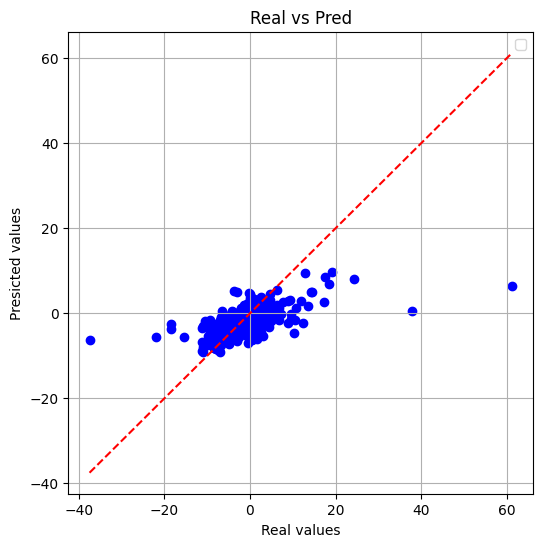

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


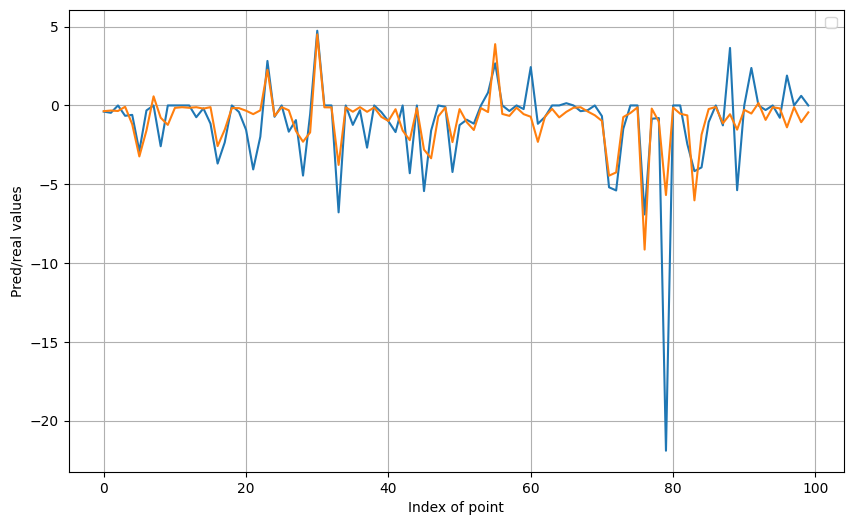

In [90]:
regression_plot1(y_test_out,y_pred_out)
regression_plot2(y_test_out,y_pred_out)

### 6. Model predicting the difference between income and expenses

In [91]:
# group the amount by user_id, by month, by direction (income and expenses) and sum them
grouped_by_month_dir = df[['user_id','month','direction','amount_n26_currency']].groupby(['user_id','month','direction']).agg('sum')

#convert them into rows
diff_ = grouped_by_month_dir.pivot_table(index='user_id', columns=['month','direction'], values='amount_n26_currency', aggfunc='sum', fill_value=0).reset_index()

# create a new column with the difference
for month in [2, 3, 4, 5, 6, 7]:
    diff_[f'{month}_diff'] = diff_[(month, 'In')] - diff_[(month, 'Out')]

# keep only user_id and the new difference columns
diff_ = diff_[['user_id'] + [f'{month}_diff' for month in [2, 3, 4, 5, 6, 7]]]

# get rid on several column levels
diff_.columns = ['_'.join(map(str, col)).strip() for col in diff_.columns]

# group the rest "types" columns
types_df = df.groupby(['user_id']).agg('sum').drop(columns=['month']).drop(columns=['amount_n26_currency','direction'])

# merge them into one dataframe
diff_ = diff_.merge(types_df, left_on='user_id_', right_on='user_id', how='outer')

diff_.columns = diff_.columns.str.rstrip('_')


In [92]:
target = '7_diff'

In [93]:
diff_

,user_id,2_diff,3_diff,4_diff,5_diff,6_diff,7_diff,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,...,mcc_explanation_Gastronomie,mcc_explanation_Groceries,"mcc_explanation_Home and DIY, House Energy",mcc_explanation_Insurance,mcc_explanation_Miscellaneous,mcc_explanation_Shopping/(Fashion),mcc_explanation_Taxes and Fines,mcc_explanation_Transport,mcc_explanation_Travel/Hotel,mcc_explanation_non-card
0,000295594379774ab9ac2c78c946d615,0.098328,1.325572,0.000000,0.480593,2.778397,0.391204,9.070228,-0.865324,0.516187,...,-4.176900,-6.766599,-1.633470,-0.334454,-3.015076,0.508756,-0.137965,-2.978460,-0.365294,-1.282893
1,000aa792d73dd82b16a29692772d395a,0.539455,0.230303,1.687851,5.772424,0.324415,1.381314,-2.344264,-1.201839,-2.496180,...,-5.801250,-3.325959,8.841529,-0.464520,-4.187605,-1.087478,-0.191619,-4.136749,-6.337936,20.340008
2,0011103fe4ba1264342882b7ab98c641,3.005580,0.230303,0.378048,0.675140,4.833839,6.486947,-3.000658,-1.538354,2.753728,...,-2.884134,-12.029509,-2.903946,-0.594585,-5.360134,-7.297068,-0.245272,7.122686,33.867636,-3.663312
3,001679c77c33d7efabf800596fb2a978,-2.352533,3.235883,9.327410,9.875298,5.326998,2.135809,-7.501645,-3.845884,-12.394323,...,-18.564001,-30.073772,-7.259865,-1.486463,-13.400336,-13.629313,-0.613180,-13.237598,-20.281395,-15.380036
4,001e72a2f4c4376f10011735dde39cd5,2.905650,1.801949,1.251953,0.031539,0.000000,0.000000,-2.062952,-1.057618,-1.205165,...,-0.563634,-8.270287,-1.996463,-0.408777,2.452412,-0.403378,-0.168624,21.195111,2.818655,-10.554963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,fff571276eaa49853039f6bfe1102fba,0.000000,0.071511,0.071511,0.000000,0.080450,0.125145,42.282229,-0.384588,-3.442706,...,-1.856400,0.028670,-0.725987,-0.148646,-1.340034,-1.824267,-0.061318,-1.323760,-2.028139,4.268970
9996,fff6ea4b3659a969c62c17c1d1655394,-1.262494,0.085173,0.400143,0.800285,0.000000,0.274998,-0.656394,-0.336515,-3.012368,...,-1.624350,0.404592,-0.635238,-0.130065,-1.172529,-1.596234,-0.053653,-1.158290,2.423397,-5.338047
9997,fff9eec15875baad3df433c8780aa3bd,3.582392,-0.042080,2.625930,0.166129,2.076947,0.409081,-2.906887,-1.490280,3.184066,...,-7.193550,-11.653587,-2.813198,-0.576004,0.944874,-2.455678,-0.237607,38.332469,17.329076,-2.900733
9998,fffd503ed2ecb63067b7369f4d668aed,0.732990,2.854631,2.818369,3.830573,6.214057,3.344163,-4.500987,-2.307531,1.376500,...,-11.138400,-2.864027,-4.355919,-0.891878,-1.902697,7.507824,-0.367908,-7.942559,4.623241,-11.716725


In [94]:
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(diff_)

len test_users: 2000
len train_users: 8000


In [95]:
X_train_diff

,2_diff,3_diff,4_diff,5_diff,6_diff,transaction_type_Cash26 deposit,transaction_type_Cash26 withdrawal,transaction_type_Credit Transfer,transaction_type_Debit Reversal,transaction_type_Debit Transfer,...,mcc_explanation_Gastronomie,mcc_explanation_Groceries,"mcc_explanation_Home and DIY, House Energy",mcc_explanation_Insurance,mcc_explanation_Miscellaneous,mcc_explanation_Shopping/(Fashion),mcc_explanation_Taxes and Fines,mcc_explanation_Transport,mcc_explanation_Travel/Hotel,mcc_explanation_non-card
0,0.098328,1.325572,0.000000,0.480593,2.778397,9.070228,-0.865324,0.516187,-1.947475,0.717187,...,-4.176900,-6.766599,-1.633470,-0.334454,-3.015076,0.508756,-0.137965,-2.978460,-0.365294,-1.282893
1,0.539455,0.230303,1.687851,5.772424,0.324415,-2.344264,-1.201839,-2.496180,-2.704827,28.501499,...,-5.801250,-3.325959,8.841529,-0.464520,-4.187605,-1.087478,-0.191619,-4.136749,-6.337936,20.340008
3,-2.352533,3.235883,9.327410,9.875298,5.326998,-7.501645,-3.845884,-12.394323,-8.655445,20.285453,...,-18.564001,-30.073772,-7.259865,-1.486463,-13.400336,-13.629313,-0.613180,-13.237598,-20.281395,-15.380036
4,2.905650,1.801949,1.251953,0.031539,0.000000,-2.062952,-1.057618,-1.205165,-2.380247,-7.300721,...,-0.563634,-8.270287,-1.996463,-0.408777,2.452412,-0.403378,-0.168624,21.195111,2.818655,-10.554963
7,-1.611111,0.000000,0.710896,0.089389,0.000000,-1.031476,-0.528809,3.528555,-1.190124,3.040144,...,-2.552550,-4.135144,-0.998231,-0.204389,10.432462,-2.508367,-0.084312,-1.820170,-2.788692,1.981235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.071511,0.071511,0.000000,0.080450,42.282229,-0.384588,-3.442706,-0.865545,0.690445,...,-1.856400,0.028670,-0.725987,-0.148646,-1.340034,-1.824267,-0.061318,-1.323760,-2.028139,4.268970
9996,-1.262494,0.085173,0.400143,0.800285,0.000000,-0.656394,-0.336515,-3.012368,-0.757351,-2.322957,...,-1.624350,0.404592,-0.635238,-0.130065,-1.172529,-1.596234,-0.053653,-1.158290,2.423397,-5.338047
9997,3.582392,-0.042080,2.625930,0.166129,2.076947,-2.906887,-1.490280,3.184066,-3.353985,-10.287379,...,-7.193550,-11.653587,-2.813198,-0.576004,0.944874,-2.455678,-0.237607,38.332469,17.329076,-2.900733
9998,0.732990,2.854631,2.818369,3.830573,6.214057,-4.500987,-2.307531,1.376500,-5.193267,-2.547837,...,-11.138400,-2.864027,-4.355919,-0.891878,-1.902697,7.507824,-0.367908,-7.942559,4.623241,-11.716725


In [96]:
model_ctb_diff = CatBoostRegressor(iterations=500, 
                                  learning_rate=0.01,                                  
                                  depth=6, 
                                  loss_function='RMSE', 
                                  verbose=50)
model_ctb_diff.fit(X_train_diff, y_train_diff, eval_set=(X_test_diff, y_test_diff))

0:	learn: 3.6896453	test: 3.8103793	best: 3.8103793 (0)	total: 9.9ms	remaining: 4.94s
50:	learn: 3.1844604	test: 3.3514455	best: 3.3514455 (50)	total: 513ms	remaining: 4.52s
100:	learn: 2.9247308	test: 3.1299144	best: 3.1299144 (100)	total: 1.01s	remaining: 3.98s
150:	learn: 2.7850465	test: 3.0215509	best: 3.0215509 (150)	total: 1.48s	remaining: 3.43s
200:	learn: 2.6991189	test: 2.9681731	best: 2.9681731 (200)	total: 1.95s	remaining: 2.9s
250:	learn: 2.6400972	test: 2.9389867	best: 2.9389867 (250)	total: 2.43s	remaining: 2.41s
300:	learn: 2.5961048	test: 2.9193297	best: 2.9193297 (300)	total: 2.85s	remaining: 1.89s
350:	learn: 2.5582662	test: 2.9062364	best: 2.9062364 (350)	total: 3.29s	remaining: 1.4s
400:	learn: 2.5250960	test: 2.8967262	best: 2.8967262 (400)	total: 3.71s	remaining: 917ms
450:	learn: 2.4963094	test: 2.8900644	best: 2.8900644 (450)	total: 4.15s	remaining: 451ms
499:	learn: 2.4708361	test: 2.8844668	best: 2.8844527 (497)	total: 4.57s	remaining: 0us

bestTest = 2.884452

In [97]:
y_pred_diff = model_ctb_diff.predict(X_test_diff)

In [98]:
mse_ctb = mean_squared_error(y_test_diff, y_pred_diff)
rmse_ctb = np.sqrt(mse_ctb)
mae_ctb = mean_absolute_error(y_test_diff, y_pred_diff)
r2_ctb = r2_score(y_test_diff, y_pred_diff)

print(f"Mean Squared Error: {mse_ctb}")
print(f"Root Mean Squared Error: {rmse_ctb}")
print(f"Mean Absolute Error: {mae_ctb}")
print(f"R-squared: {r2_ctb}")

results.append([mse_ctb, rmse_ctb, mae_ctb, r2_ctb])

Mean Squared Error: 8.32006758409961
Root Mean Squared Error: 2.8844527356328116
Mean Absolute Error: 1.5707454671717327
R-squared: 0.4308140761252297


C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1317986700.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


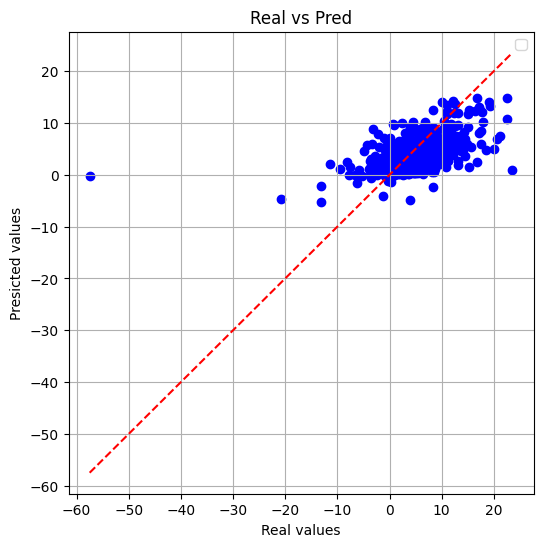

C:\Users\natal\AppData\Local\Temp\ipykernel_12460\1392270024.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


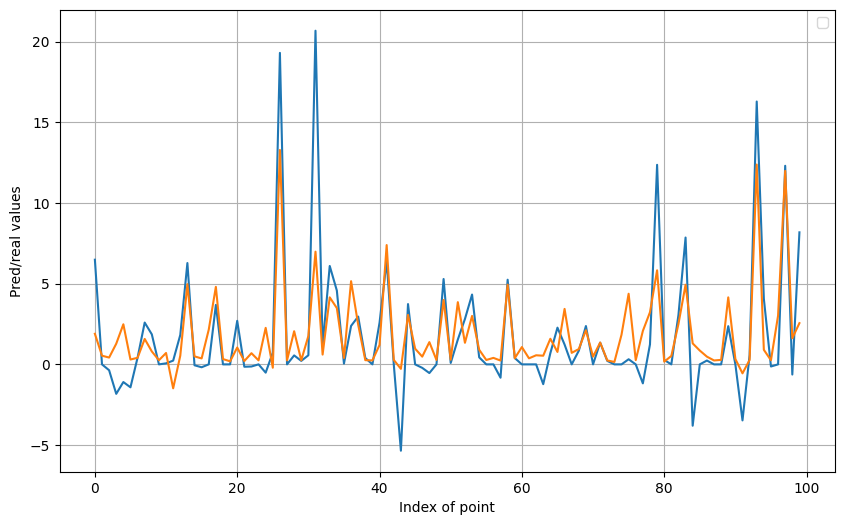

In [99]:
regression_plot1(y_test_diff,y_pred_diff)
regression_plot2(y_test_diff,y_pred_diff)